# **TRABALHO 3** MapReduce Apache Spark - Cloud

* Antonia Raiane Santos Araujo Cruz
* Jerry Macedo

### **Contextualização**

As questões solicitadas estão apresetadas na sequência da especificação da tarefa. O relatório será feito também neste notebook, obedecendo a sequência dos itens, conforme solicitado: descrição do ambiente utilizado para execução das aplicações Hadoop; ecada item deve ser respondido e devidamente explicado como o resultado foi encontrado em um ou dois parágrafos;

> Os datasets poderão ser obtidos [Downlaod Datasets](https://drive.google.com/drive/mobile/folders/0BzwVBj1heLoReXVLaU51bTAxZ2M?usp=sharing)
* Link do vídeo: 

### Descrição do ambiente

Incialmente utilizamos o Google Colaboratory, entretando após alguns erros em relação ao tratamento dos campos com datas, mudou-se os experimentos para outro ambiente. Inciou-se então os experimentos utilizando o Jupyter Notebook (com a instalação do Anaconda Navigator). Na sequência instalamos o `python3`, e o pacote `Pyshark` (Spark com Python) 3.3.1, (`spark-3.1.2-bin-hadoop2.7`) e o `java 8`. A máquina utilizada apresenta uma configuração de S.O Windows 10, 8 GB de RAM e disco SSD de 250 GB. 

### Instalando as dependências

O PySpark é uma biblioteca Spark escrita em Python para executar aplicativos Python usando os recursos do Apache Spark. Usando o PySpark podemos executar aplicativos paralelamente no cluster distribuído (em vários nós). O Apache Spark funciona em uma arquitetura master-slave onde o master é chamado de “Driver” e os slaves são chamados de “Workers”. Quando executamos um aplicativo Spark, o Spark Driver cria um contexto que é um ponto de entrada para seu aplicativo e todas as operações que serão executadas em nós de trabalho e os recursos são gerenciados pelo Cluster Manager.



> * **Driver Program**: é a aplicação principal que gerencia a criação e é quem executará o processamento definido.
> * **Cluster Manager**:  é um componente opcional que só é necessário se o Spark for executado de forma distribuída. Ele é responsável por administrar as máquinas que serão utilizadas como *workers*;
> * **Workers**: são as máquinas que realmente executarão as tarefas que são enviadas pelo Driver Program. Se o Spark for executado de forma local, a máquina desempenhará tanto o papel de Driver Program como de Worker.

In [464]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


Após instalação, definimos as seguintes variáveis de ambiente.

In [659]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"   

Abaixo, são importadas as bibliotecas necessárias para a execução de algumas  das tarefas realizadas, como as bibliotecas para  criação da sessão, funções sql, types para a definimos do `schema`, funções para o timestamp e regex.

In [462]:
from pyspark.sql import SparkSession
from pyspark.sql.types import * 
from pyspark.sql.functions import *
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, udf, to_timestamp, hour,from_utc_timestamp, regexp_extract
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt


Em seguida criou-se uma Sessão Spark, onde é possível configurar os nós do cluster, bem como a memória alocada para cada um deles. O Apache Spark fornece um conjunto de interfaces de usuário da Web (trabalhos, estágios, tarefas, armazenamento, ambiente, executores e SQL) para monitorar o status de seu aplicativo `Spark` , o consumo de recursos do cluster Spark e as configurações do Spark. No `Spark Web UI`, você pode ver como as operações são executadas.

In [543]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("TrabalhoMapReduce") \
    .config('spark.ui.port', '4041') \
    .config("spark.memory.offHeap.enabled","true")\
     .config("spark.memory.offHeap.size","10g")\
    .getOrCreate()

In [473]:
spark

Para além da arquitetura do modelo de programação do Spark, também podemos definir os conceitos de `Resilient Distributed Datasets` (RDD) que são utilizados para abstrair um conjunto de objetos distribuídos no cluster, normalmente executados na memória principal. Representam a finalidade principal do modelo de programação do `Spark`, pois são nesses objetos que executa-se o processamento dos dados.

Outro aspecto importante são as `operações` que represetam  as transformações realizadas (como agrupamentos, filtros e mapeamentos entre os dados) ou `ações` (como contagens e persistências) que são realizados em um RDD. Já o `Spark Context` é o objeto que conecta o Spark ao programa que está sendo desenvolvido. No caso deste processamento, podemos acessar o Sparl Context pela variável `spark`, conforme célula acima.

In [476]:
get_ipython().system_raw('./ngrok authtoken 2IdsLU5nGafRfq650p5MAO8GJ1D_7qUYgZtkBw8QLPF25JaF4')
get_ipython().system_raw('./ngrok http 4050 &')

In [477]:
!curl -s http://localhost:4041/api/tunnels

## **Questões**


### Questão2) Dado um dataset com tweets relacionados à campanha eleitoral presidencial de 2014, responda:

Para o uso deste dataset foi utilizado a descrição do dataset conforme disponibilizadono link abaixo:
Descrição:
- debate-tweets.tsv: http://lia.ufc.br/~igobrilhante/twitter-home/
- eiffel-tower-reviews.json: Cada linha é um son com representação do review

Para o dataset utilizamos o `schema`conforme a descrição acima, através da estrutura `StructType`, definindo assim as `fields`que poderão ser acessadas posteriormente pela posição ou nome.

In [364]:
schemaDfDebate = StructType() \
      .add("id",LongType(),True) \
      .add("content",StringType(),True) \
      .add("coordinate_0",StringType(),True) \
      .add("coordiante_1",StringType(),True) \
      .add("retweeted",StringType(),True) \
      .add("tweet_id",StringType(),True) \
      .add("tweet_id_str",StringType(),True) \
      .add("created_at",StringType(),True) \
      .add("created_at_str",StringType(),True) \
      .add("in_reply_to_user_id",StringType(),True) \
      .add("lang",StringType(),True) \
      .add("place_name",StringType(),True) \
      .add("place_id",StringType(),True) \
      .add("place_bb_00",StringType(),True) \
      .add("place_bb_01",StringType(),True) \
      .add("place_bb_10",StringType(),True) \
      .add("place_bb_11",StringType(),True) \
      .add("place_bb_20",StringType(),True) \
      .add("place_bb_21",StringType(),True) \
      .add("place_bb_30",StringType(),True) \
      .add("place_bb_31",StringType(),True) \
      .add("place_type",StringType(),True) \
      .add("place_country_code",StringType(),True) \
      .add("place_country",StringType(),True) \
      .add("place_full_name",StringType(),True) \
      .add("user_name",StringType(),True) \
      .add("user_id",StringType(),True) \
      .add("user_id_str",StringType(),True) \
      .add("user_location",StringType(),True) \
      .add("user_friend_count",StringType(),True) \
      .add("user_created_at",StringType(),True) \
      .add("user_screen_name",StringType(),True) 


In [ ]:
A seguir

In [365]:
dfDebate = spark.read.csv("debate-tweets.tsv",sep=r'\t',schema=schemaDfDebate)
dfDebate.printSchema()

root
 |-- id: long (nullable = true)
 |-- content: string (nullable = true)
 |-- coordinate_0: string (nullable = true)
 |-- coordiante_1: string (nullable = true)
 |-- retweeted: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet_id_str: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- created_at_str: string (nullable = true)
 |-- in_reply_to_user_id: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- place_name: string (nullable = true)
 |-- place_id: string (nullable = true)
 |-- place_bb_00: string (nullable = true)
 |-- place_bb_01: string (nullable = true)
 |-- place_bb_10: string (nullable = true)
 |-- place_bb_11: string (nullable = true)
 |-- place_bb_20: string (nullable = true)
 |-- place_bb_21: string (nullable = true)
 |-- place_bb_30: string (nullable = true)
 |-- place_bb_31: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- place_country_code: string (nullable = true)
 |-- place_country

In [323]:
dfDebate

DataFrame[id: bigint, content: string, coordinate_0: string, coordiante_1: string, retweeted: string, tweet_id: string, tweet_id_str: string, created_at: string, created_at_str: string, in_reply_to_user_id: string, lang: string, place_name: string, place_id: string, place_bb_00: string, place_bb_01: string, place_bb_10: string, place_bb_11: string, place_bb_20: string, place_bb_21: string, place_bb_30: string, place_bb_31: string, place_type: string, place_country_code: string, place_country: string, place_full_name: string, user_name: string, user_id: string, user_id_str: string, user_location: string, user_friend_count: string, user_created_at: string, user_screen_name: string]

In [283]:
type(dfDebate)

pyspark.sql.dataframe.DataFrame

In [284]:
(dfDebate.count(), len(dfDebate.columns))

(7228127, 32)

In [285]:
dfDebate.take(2)

[Row(id=522394422710136832, content='@anacddd verdade, olha o site', coordinate_0='-27.516566', coordiante_1='-48.646082', retweeted='False', tweet_id='522394422710136832', tweet_id_str='522394422710136832', created_at='Wed Oct 15 14:31:50 +0000 2014', created_at_str='2014-10-15', in_reply_to_user_id='303425830', lang='pt', place_name='Biguaçu', place_id='77c15e08a456c529', place_bb_00='0.0', place_bb_01='0.0', place_bb_10='0.0', place_bb_11='0.0', place_bb_20='0.0', place_bb_21='0.0', place_bb_30='0.0', place_bb_31='0.0', place_type=None, place_country_code=None, place_country=None, place_full_name=None, user_name='Geovana Nunes', user_id='295414968', user_id_str='295414968', user_location=None, user_friend_count='316', user_created_at='Mon May 09 00:12:02 +0000 2011', user_screen_name='geovanannunes'),
 Row(id=522394422806581248, content='Que ñ*', coordinate_0='-27.768328', coordiante_1='-51.668323', retweeted='False', tweet_id='522394422806581248', tweet_id_str='522394422806581248',

In [286]:
dfDebate.limit(10).toPandas()

,id,content,coordinate_0,coordiante_1,retweeted,tweet_id,tweet_id_str,created_at,created_at_str,in_reply_to_user_id,...,place_country_code,place_country,place_full_name,user_name,user_id,user_id_str,user_location,user_friend_count,user_created_at,user_screen_name
0,522394422710136832,"@anacddd verdade, olha o site",-27.516566,-48.646082,False,522394422710136832,522394422710136832,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,303425830,...,None,None,None,Geovana Nunes,295414968,295414968,None,316,Mon May 09 00:12:02 +0000 2011,geovanannunes
1,522394422806581248,Que ñ*,-27.768328,-51.668323,False,522394422806581248,522394422806581248,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,Rosane Fernandes,2409363642,2409363642,Cacique Doble RS,47,Mon Mar 24 18:06:40 +0000 2014,Rosane_fsf
2,522394422731100160,Vou quebrar a Bruna,-27.00464,-48.623519,False,522394422731100160,522394422731100160,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,Bebel,162447082,162447082,None,513,Sat Jul 03 18:03:35 +0000 2010,_isarenata
3,522394422810783745,agora vou p segundo andar e depois p 3° 👏,-15.852082,-47.961413,False,522394422810783745,522394422810783745,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,tatá,387694391,387694391,None,347,Sun Oct 09 14:19:52 +0000 2011,thayflausino
4,522394423137943553,Me sinto tão bem - Mika #QueroNoTVZ,-3.755046,-38.566769,False,522394423137943553,522394423137943553,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,Simone ♥ DDM's ♥,152792963,152792963,Fortaleza/Ceará,719,Sun Jun 06 22:15:22 +0000 2010,simoneesilva
5,522394423188271104,"Eu estou aqui, deixando a vida me guiar, não é...",-22.846869,-43.30883,False,522394423188271104,522394423188271104,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,Gar6,749780077,749780077,Rio de Janeiro,356,Fri Aug 10 17:56:10 +0000 2012,juliagar6
6,522394423238606848,Quando vai embora tudo fica sem graça,-22.904301,-43.544403,False,522394423238606848,522394423238606848,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,Isa,2476253858,2476253858,None,164,Sun May 04 02:22:02 +0000 2014,isabelleecorrea
7,522394423528022016,@paynecaralhudo kkkkkk n n sou legal kkk,-23.509058,-46.96892,False,522394423528022016,522394423528022016,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,518826601,...,None,None,None,Júlio Lessa ✌,324937648,324937648,None,943,Mon Jun 27 13:28:08 +0000 2011,SiempreCtgLS
8,522394423632875521,Conceição da Barra acho que vou pra outro dia,-18.713338,-40.405779,False,522394423632875521,522394423632875521,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,♔Lu♔,536501962,536501962,Nova Venécia-Es,82,Sun Mar 25 17:45:22 +0000 2012,Hey_Marrenta
9,522394424010362881,@Maniavato te amo ♥,-23.064705,-45.717173,False,522394424010362881,522394424010362881,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,542665678,...,None,None,None,queen,1414028317,1414028317,| no puteiro com a Ju. |,1911,Wed May 08 22:50:20 +0000 2013,ButeraCertified


In [324]:
dfDebate.select(dfDebate['user_created_at'], dfDebate['created_at']).show(5,truncate=False)

+------------------------------+------------------------------+
|user_created_at               |created_at                    |
+------------------------------+------------------------------+
|Mon May 09 00:12:02 +0000 2011|Wed Oct 15 14:31:50 +0000 2014|
|Mon Mar 24 18:06:40 +0000 2014|Wed Oct 15 14:31:50 +0000 2014|
|Sat Jul 03 18:03:35 +0000 2010|Wed Oct 15 14:31:50 +0000 2014|
|Sun Oct 09 14:19:52 +0000 2011|Wed Oct 15 14:31:50 +0000 2014|
|Sun Jun 06 22:15:22 +0000 2010|Wed Oct 15 14:31:50 +0000 2014|
+------------------------------+------------------------------+
only showing top 5 rows



In [366]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
dfDebateDate=dfDebate.withColumn("date",to_timestamp('created_at', 'EEE LLL d HH:mm:ss z yyyy'))
dfDebateFiltro=dfDebateDate.select('content','created_at',"date")

In [389]:
dfHashtag=dfDebateFiltro.filter(dfDebateFiltro["content"].rlike("^#\w+|\s#\w+")).withColumn("hashtag",regexp_extract("content","^#\w+|\s#\w+",0))\
.withColumn("hora",hour("date"))
dfHashtag.show(5)

+--------------------+--------------------+-------------------+--------------------+----+
|             content|          created_at|               date|             hashtag|hora|
+--------------------+--------------------+-------------------+--------------------+----+
|Me sinto tão bem ...|Wed Oct 15 14:31:...|2014-10-15 11:31:50|         #QueroNoTVZ|  11|
|#EMABiggestFansJu...|Wed Oct 15 14:31:...|2014-10-15 11:31:50|#EMABiggestFansJu...|  11|
|Dr. Bieber #EMABi...|Wed Oct 15 14:31:...|2014-10-15 11:31:51| #EMABiggestFansJ...|  11|
|MIDNIGHT MEMORIES...|Wed Oct 15 14:31:...|2014-10-15 11:31:51|   #EMABiggestFans1D|  11|
|#EMABiggestFans1D...|Wed Oct 15 14:31:...|2014-10-15 11:31:52|   #EMABiggestFans1D|  11|
+--------------------+--------------------+-------------------+--------------------+----+
only showing top 5 rows



### a) Quais foram as hashtags mais usadas pela manhã, tarde e noite?

Inicialmente foi considerando um intervalo de tempo para cada turno. Considerando o período da manhã de 06h até as 12h, período da tarde de 12h as 18h e noite de 18h até as 6h da manhã.

In [397]:
dfHashtag_manha=dfHashtag.filter((dfHashtag["hora"]>=6) & (dfHashtag["hora"]<12));
dfHashtag_manha.count()

118999

Desta forma, no período da manhã nota-se que foram twets com 118999 hashtags, sendo que desse valor optamos por apresentar apenas as 10 hashtags mais usadas. Conforme abaixo:

In [391]:
print("Top 10 das hastags mais usadas pela manhã:")
dfHashtag_manha.groupby("hashtag", "hora").count().sort('count', ascending=False).limit(10).show()

Top 10 das hastags mais usadas pela manhã:
+--------------------+-----+
|             hashtag|count|
+--------------------+-----+
|   #EMABiggestFans1D|27832|
| #EMABiggestFansJ...|23003|
|#EMABiggestFansJu...| 2674|
|   #EMABiggestFans1D| 2313|
|         #QueroNoTVZ| 2217|
|         #QueroNoTVZ| 1402|
| #VoteVampsTeenAw...|  976|
|       #AUSTINMAHONE|  694|
|       #AustinMahone|  620|
|             #trndnl|  482|
+--------------------+-----+



Em relação ao período da tarde, observamos que foram twetadas 267072 hashtags.

In [392]:
dfHashtag_tarde=dfHashtag.filter((dfHashtag["hora"]>=12) & (dfHashtag["hora"]<18));
dfHashtag_tarde.count()

267072

Abaixo apresentamos o top 10 hashtags usadas à tarde.

In [393]:
print("Top 10 das hastags mais usas pela tarde:")
dfHashtag_tarde.groupby("hashtag").count().sort('count', ascending=False).limit(10).show()

Top 10 das hastags mais usas pela tarde:
+--------------------+-----+
|             hashtag|count|
+--------------------+-----+
|   #EMABiggestFans1D|57515|
| #EMABiggestFansJ...|52163|
|#EMABiggestFansJu...| 6057|
|        #StealMyGirl| 5918|
|   #EMABiggestFans1D| 4812|
|   #bigpaynodanceoff| 3649|
| #LuanSantanaNaHo...| 2872|
|    #CartersNewVideo| 1679|
|     #FlyNoMixDiario| 1141|
|       #AustinMahone| 1040|
+--------------------+-----+



Enquanto que à noite tivemos um total de 487219 hashtags, cosniderando o filtro de horário das 18h as 06h. Logo em seguida visualizamos as 10 hashtgas mais twetadas.

In [394]:
dfHashtag_noite=dfHashtag.filter(dfHashtag["hora"]>=18).union(dfHashtag.filter(dfHashtag["hora"]<6));
dfHashtag_noite.count()

487219

In [398]:
print("Top 10 das hastags mais usas pela noite:")
dfHashtag_noite.groupby("hashtag").count().sort('count', ascending=False).limit(10).show()

Top 10 das hastags mais usas pela noite:
+--------------------+------+
|             hashtag| count|
+--------------------+------+
| #EMABiggestFansJ...|104327|
|   #EMABiggestFans1D|104241|
|#EMABiggestFansJu...| 14142|
|       #camilasayshi|  9024|
|   #EMABiggestFans1D|  8587|
|     #TheVoiceBrasil|  2315|
|        #DebateNoSBT|  2229|
|                  #E|  2037|
|        #AssistamODR|  1953|
|          #Vote5HEMA|  1952|
+--------------------+------+



### b) Quais as hashtags mais usadas em cada dia?

#Texto

In [497]:
dfHashtag_info_data=dfDebateDate.filter(dfDebateDate["content"].rlike("^#\w+|\s#\w+"))\
    .withColumn("minutos",F.minute("date"))\
    .withColumn("hora",F.hour("date"))\
    .withColumn("dia",F.dayofmonth("date"))\
    .withColumn("mês",F.month("date"))\
    .withColumn("diaSemana", F.date_format(col("date"), "E"))\
    .withColumn("hashtag",regexp_extract("content","^#\w+|\s#\w+",0)).select("dia","mês","hora", "minutos","diaSemana","hashtag", "content");
dfHashtag_info_data

DataFrame[dia: int, mês: int, hora: int, minutos: int, diaSemana: string, hashtag: string, content: string]

In [400]:
dfHashtag_info_data

DataFrame[dia: int, mês: int, hora: int, minutos: int, hashtag: string]

In [403]:
dfHashtag_dia_final=dfHashtag_info_data.groupby("dia","mês","hashtag").count().sort("count", ascending=False)
print("As hastags mais usadas por dia:")
dfHashtag_dia_final.toPandas()

As hastags mais usadas por dia:


,dia,mês,hashtag,count
0,16.0,10.0,#EMABiggestFans1D,58662
1,16.0,10.0,#EMABiggestFansJustinBieber,46097
2,15.0,10.0,#EMABiggestFans1D,43730
3,15.0,10.0,#EMABiggestFansJustinBieber,40738
4,17.0,10.0,#EMABiggestFans1D,32530
...,...,...,...,...
148127,20.0,10.0,#Tw10000,1
148128,20.0,10.0,#arisjerome,1
148129,20.0,10.0,#TeAmoooo,1
148130,20.0,10.0,#primogato,1


### c) Qual o número de tweets por hora a cada dia? 

In [500]:
dfHashtag_hora_final=dfHashtag_info_data.groupBy("dia","mês","hora","hashtag").count().sort("count", ascending=False)
print("As hastags mais usadas por hora a cada dia:")
dfHashtag_hora_final.toPandas()

As hastags mais usadas por hora a cada dia:


,dia,mês,hora,hashtag,count
0,15.0,10.0,22.0,#EMABiggestFansJustinBieber,8738
1,15.0,10.0,22.0,#camilasayshi,8513
2,15.0,10.0,23.0,#EMABiggestFans1D,6731
3,16.0,10.0,22.0,#EMABiggestFansJustinBieber,6504
4,15.0,10.0,22.0,#EMABiggestFans1D,5994
...,...,...,...,...,...
208921,20.0,10.0,2.0,#TeSigoEsperando,1
208922,20.0,10.0,3.0,#parei,1
208923,20.0,10.0,4.0,#muitoamorenvolvido,1
208924,20.0,10.0,4.0,#fui,1


In [501]:
dfHashtag_hora_final=dfHashtag_info_data.groupBy("diaSemana","mês","hora","hashtag").count().sort("count", ascending=False)
print("As hastags mais usadas por hora a cada dia:")
dfHashtag_hora_final.limit(10).toPandas()

As hastags mais usadas por hora a cada dia:


,diaSemana,mês,hora,hashtag,count
0,Wed,10,22,#EMABiggestFansJustinBieber,8738
1,Wed,10,22,#camilasayshi,8513
2,Wed,10,23,#EMABiggestFans1D,6731
3,Thu,10,22,#EMABiggestFansJustinBieber,6504
4,Wed,10,22,#EMABiggestFans1D,5994
5,Wed,10,23,#EMABiggestFansJustinBieber,5969
6,Thu,10,22,#EMABiggestFans1D,4933
7,Thu,10,23,#EMABiggestFansJustinBieber,4614
8,Fri,10,0,#EMABiggestFans1D,4569
9,Thu,10,23,#EMABiggestFans1D,4498


In [412]:
dfHashtag_hora_final=dfHashtag_info_data.groupBy("dia","hora","content").count().sort("count", ascending=False)
print("As hastags mais usadas por hora a cada dia:")
dfHashtag_hora_final.toPandas()

As hastags mais usadas por hora a cada dia:


,dia,hora,content,count
0,15.0,22.0,#EMABiggestFansJustinBieber,112
1,15.0,23.0,MTV EMA | Vote - http://t.co/Ro4Y4aXn5A #EMABi...,100
2,16.0,0.0,MTV EMA | Vote - http://t.co/XUIMfCFG2L #EMABi...,93
3,16.0,22.0,#EMABiggestFansJustinBieber,63
4,15.0,23.0,#EMABiggestFansJustinBieber,57
...,...,...,...,...
848939,20.0,2.0,O povo da minha sala me odeia 😂 #EMABiggestFan...,1
848940,20.0,3.0,#brotherlylove #puggles and #george #puppies #...,1
848941,20.0,4.0,#Top3Apps for 'Luan e Letícia' Twitter for An...,1
848942,20.0,4.0,cento e noventa e dois #EMABiggestFansJustinBi...,1


### d) Quais as principais sentenças relacionadas à palavra “Dilma”?

In [429]:
dfDebateDilma=dfDebateTimestamp.filter(lower(dfDebateTimestamp["content"]).contains("dilma"))\
.groupBy("content").count().sort("count",ascending=False)
dfDebateDilma.toPandas()

,content,count
0,#QueroDilmaTreze,110
1,#MelhorcomDilma13,34
2,#MenosOdioMaisDilma,29
3,#Dilma13,24
4,#dilmavaiperderaecio45vencer,24
...,...,...
36216,"Por que o PT é perverso, segundo o Aécio? Se e...",1
36217,1. #MadrugadaDoSdvComTiuMarkito 2. #QueroDilma...,1
36218,@cristilobo @Fabio_Lemos55 Mas ela não consegu...,1
36219,Fora tucanos! PT mais quatro anos! #souDilma13...,1


In [424]:
print("Top 10 sentenças relacionadas à palavra Dilma:")
dfDebateDilma.limit(10).toPandas()

Top 10 sentenças relacionadas à palavra Dilma:


,content,count
0,#QueroDilmaTreze,110
1,#MelhorcomDilma13,34
2,#MenosOdioMaisDilma,29
3,#dilmavaiperderaecio45vencer,24
4,#Dilma13,24
5,#VouComDilma13,24
6,#DilmaTheVodka,21
7,#QueroDilma13,15
8,#Dilma13PraVencer,13
9,Dilma 13,7


### e) Quais as principais sentenças relacionadas à palavra “Aécio”?

In [205]:
dfDebateAecio=dfDebateTimestamp.filter(lower(dfDebateTimestamp["content"]).contains("aécio"))\
.groupBy("content").count().sort("count",ascending=False)
print("Top 10 sentenças relacionadas à palavra Aécio:")
dfDebateAecio.limit(10).toPandas()

Top 10 sentenças relacionadas à palavra Aécio:


,content,count
0,#AgoraÉAécioBrasil,10
1,#EmTodoBrasilAécio45,9
2,Aé aé aé Aécio,6
3,#AgoraBrasilAécio45,6
4,#Aécio45,6
5,Aécio,5
6,"— Dilma ou Aécio? — Dois hambúrgueres, alface,...",5
7,Aécio 45,4
8,"Aécio, aprovado até pela Dilma",4
9,Só pra lembrar: Aécio 45 Dilma 13 CPM 22 Nx 0 ...,4


### Questão 3) Dado um dataset com tweets relacionados à visita da Torre Eiffel em Paris, responda:

In [435]:
sc=spark.sparkContext

In [436]:
spark.sparkContext

<SparkContext master=local[*] appName=TrabalhoMapReduce>

In [437]:
dfEiffel = spark.read.json("eiffel-tower-reviews.json")
dfEiffel.columns

['_id',
 'author',
 'bubbleCount',
 'collectedAt',
 'createdAt',
 'query',
 'text',
 'title']

In [438]:
dfEiffel.toPandas()

,_id,author,bubbleCount,collectedAt,createdAt,query,text,title
0,"(5921cdae4b679c4646a52f57,)","(0, 0, Since this month, 0, 0, 2)",50,"(2017-05-21T17:26:06.452Z,)","May 20, 2017",Eiffel_Tower,This is the most busiest atttaction in Paris a...,Must do even it was so busy
1,"(5921cdae4b679c4646a52f58,)","(10, 4, Since Aug 2015, 0, 23, 27)",50,"(2017-05-21T17:26:06.590Z,)","May 20, 2017",Eiffel_Tower,My significant other and I drunkenly stumbled ...,A Classic
2,"(5921cdae4b679c4646a52f59,)","(9, 4, Since Nov 2015, 0, 0, 31)",50,"(2017-05-21T17:26:06.642Z,)","May 20, 2017",Eiffel_Tower,We had a tour to the Eiffel Tower while we wer...,Wet weather
3,"(5921cdae4b679c4646a52f5a,)","(16, 5, Since Apr 2008, 0, 536, 37)",50,"(2017-05-21T17:26:06.721Z,)","May 20, 2017",Eiffel_Tower,Visited with my wife and son.,Not to be missed
4,"(5921cdae4b679c4646a52f5b,)","(30, 6, Since Jan 2014, 0, 36, 181)",50,"(2017-05-21T17:26:06.757Z,)","May 20, 2017",Eiffel_Tower,We went in the night at 10pm to see the illumi...,Awesome!!!
...,...,...,...,...,...,...,...,...
7174,"(59226b566af3a1312785d4f3,)","(0, 0, Since Jul 2015, 0, 0, 2)",30,"(2017-05-22T04:38:46.565Z,)","July 27, 2015",Eiffel_Tower,We recently visited the Eiffel Tower on our tr...,Tour me Eiffel
7175,"(59226b566af3a1312785d4f4,)","(13, 4, Since May 2009, 0, 15, 31)",40,"(2017-05-22T04:38:46.712Z,)","July 27, 2015",Eiffel_Tower,Getting through the lines is impossible or at ...,Bucket list must see
7176,"(59226b566af3a1312785d4f5,)","(47, 5, Since Oct 2010, 0, 1, 76)",50,"(2017-05-22T04:38:46.854Z,)","July 27, 2015",Eiffel_Tower,One must not be there to be served and one wil...,Crowded with awful staff. But who cares? It's ...
7177,"(59226b566af3a1312785d4f6,)","(0, 2, Since Aug 2012, 0, 0, 6)",50,"(2017-05-22T04:38:46.947Z,)","July 27, 2015",Eiffel_Tower,Loved the Eiffel tower this was my 2nd visit a...,AMAZING


In [439]:
print('Número de linhas no arquivo: %s' % dfEiffel.count())

Número de linhas no arquivo: 7179


### a) Encontre as palavras mais utilizadas nas avaliações.

In [440]:
dfEiffelDate=dfEiffel.withColumn("date",to_date('createdAt', 'MMM d,yyyy'))
dfEiffelDate.toPandas()

,_id,author,bubbleCount,collectedAt,createdAt,query,text,title,date
0,"(5921cdae4b679c4646a52f57,)","(0, 0, Since this month, 0, 0, 2)",50,"(2017-05-21T17:26:06.452Z,)","May 20, 2017",Eiffel_Tower,This is the most busiest atttaction in Paris a...,Must do even it was so busy,2017-05-20
1,"(5921cdae4b679c4646a52f58,)","(10, 4, Since Aug 2015, 0, 23, 27)",50,"(2017-05-21T17:26:06.590Z,)","May 20, 2017",Eiffel_Tower,My significant other and I drunkenly stumbled ...,A Classic,2017-05-20
2,"(5921cdae4b679c4646a52f59,)","(9, 4, Since Nov 2015, 0, 0, 31)",50,"(2017-05-21T17:26:06.642Z,)","May 20, 2017",Eiffel_Tower,We had a tour to the Eiffel Tower while we wer...,Wet weather,2017-05-20
3,"(5921cdae4b679c4646a52f5a,)","(16, 5, Since Apr 2008, 0, 536, 37)",50,"(2017-05-21T17:26:06.721Z,)","May 20, 2017",Eiffel_Tower,Visited with my wife and son.,Not to be missed,2017-05-20
4,"(5921cdae4b679c4646a52f5b,)","(30, 6, Since Jan 2014, 0, 36, 181)",50,"(2017-05-21T17:26:06.757Z,)","May 20, 2017",Eiffel_Tower,We went in the night at 10pm to see the illumi...,Awesome!!!,2017-05-20
...,...,...,...,...,...,...,...,...,...
7174,"(59226b566af3a1312785d4f3,)","(0, 0, Since Jul 2015, 0, 0, 2)",30,"(2017-05-22T04:38:46.565Z,)","July 27, 2015",Eiffel_Tower,We recently visited the Eiffel Tower on our tr...,Tour me Eiffel,2015-07-27
7175,"(59226b566af3a1312785d4f4,)","(13, 4, Since May 2009, 0, 15, 31)",40,"(2017-05-22T04:38:46.712Z,)","July 27, 2015",Eiffel_Tower,Getting through the lines is impossible or at ...,Bucket list must see,2015-07-27
7176,"(59226b566af3a1312785d4f5,)","(47, 5, Since Oct 2010, 0, 1, 76)",50,"(2017-05-22T04:38:46.854Z,)","July 27, 2015",Eiffel_Tower,One must not be there to be served and one wil...,Crowded with awful staff. But who cares? It's ...,2015-07-27
7177,"(59226b566af3a1312785d4f6,)","(0, 2, Since Aug 2012, 0, 0, 6)",50,"(2017-05-22T04:38:46.947Z,)","July 27, 2015",Eiffel_Tower,Loved the Eiffel tower this was my 2nd visit a...,AMAZING,2015-07-27


In [637]:
dfEiffelWordCount=dfEiffelFiltro.withColumn("words",split('text', ' '))\
.withColumn('word', explode('words')).select("word").withColumn("wordTopics",lower(col("word"))).select("word","wordTopics")\
.groupby("wordTopics").count().orderBy("count",ascending=False).select("wordTopics","count")

dfEiffelWordCount.limit(10).toPandas()

,wordTopics,count
0,the,29512
1,to,14835
2,and,11161
3,a,9028
4,of,6998
5,it,6381
6,you,6007
7,in,5903
8,we,5778
9,is,5761


As famosas Stopwords (ou palavras de parada – tradução livre) são palavras que podem ser consideradas irrelevantes para o conjunto de resultados a ser exibido em uma busca realizada em uma Search Engine. 

In [521]:
dfEiffelFiltro = dfEiffel.drop('_id', 'author', 'bubbleCount', 'collectedAt', 'createdAt', 'query', 'title')
dfEiffelFiltro.show()

+--------------------+
|                text|
+--------------------+
|This is the most ...|
|My significant ot...|
|We had a tour to ...|
|Visited with my w...|
|We went in the ni...|
|Dont hesitate and...|
|I enjoyed the tow...|
|Read through the ...|
|This by far was o...|
|Something you hav...|
|The views are bea...|
|Worth spending a ...|
|Took the tour to ...|
|A fantastic fusio...|
|Whatever you do i...|
|Not to miss..beau...|
|We visited in the...|
|Go for sunset and...|
|We booked weeks a...|
|Eiffel Tower is j...|
+--------------------+
only showing top 20 rows



In [577]:
dfEiffelFiltro.withColumn('text', F.explode(F.split(F.col('text'), ' '))) \
  .groupBy('text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+------+-----+
|  text|count|
+------+-----+
|   the|26696|
|    to|14756|
|   and|10980|
|     a| 8509|
|    of| 6912|
|    in| 5771|
|    is| 5735|
|   you| 5237|
|   was| 4950|
|    it| 4923|
|     I| 3944|
|   for| 3626|
|    at| 3524|
|Eiffel| 3090|
|    up| 3057|
|    we| 3016|
|    on| 2968|
|   The| 2793|
|   but| 2778|
|    We| 2758|
+------+-----+
only showing top 20 rows



In [551]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="text", outputCol="text_token")
tokenized = tokenizer.transform(dfEiffelFiltro)
print('############ Tokenized data extract:')
tokenized.show()


############ Tokenized data extract:
+--------------------+--------------------+
|                text|          text_token|
+--------------------+--------------------+
|This is the most ...|[this, is, the, m...|
|My significant ot...|[my, significant,...|
|We had a tour to ...|[we, had, a, tour...|
|Visited with my w...|[visited, with, m...|
|We went in the ni...|[we, went, in, th...|
|Dont hesitate and...|[dont, hesitate, ...|
|I enjoyed the tow...|[i, enjoyed, the,...|
|Read through the ...|[read, through, t...|
|This by far was o...|[this, by, far, w...|
|Something you hav...|[something, you, ...|
|The views are bea...|[the, views, are,...|
|Worth spending a ...|[worth, spending,...|
|Took the tour to ...|[took, the, tour,...|
|A fantastic fusio...|[a, fantastic, fu...|
|Whatever you do i...|[whatever, you, d...|
|Not to miss..beau...|[not, to, miss..b...|
|We visited in the...|[we, visited, in,...|
|Go for sunset and...|[go, for, sunset,...|
|We booked weeks a...|[we, booked, week

In [568]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [597]:
transformed_string=dfEiffelFiltroClean.replace(", ","")
print("Transformed String is:")
print(transformed_string)
transformed_string.show()

Transformed String is:
DataFrame[text_clean: array<string>]
+--------------------+
|          text_clean|
+--------------------+
|[busiest, atttact...|
|[significant, dru...|
|[tour, eiffel, to...|
|[visited, wife, s...|
|[went, night, 10p...|
|[dont, hesitate, ...|
|[enjoyed, tower, ...|
|[read, history, e...|
|[far, favourite, ...|
|[something, visit...|
|[views, beautiful...|
|[worth, spending,...|
|[took, tour, top,...|
|[fantastic, fusio...|
|[whatever, afford...|
|[miss..beautiful,...|
|[visited, afterno...|
|[go, sunset, stay...|
|[booked, weeks, a...|
|[eiffel, tower, l...|
+--------------------+
only showing top 20 rows



### b) Encontre as expressões mais usadas. Considere uma expressão um conjunto de palavras na sequencia. O tamanho da sequencia pode ser determinado por você.

In [657]:
from pyspark.ml.feature import NGram
dfEiffelExpressoes=dfEiffelFiltro.withColumn("expressoes",sentences("text"))\
    .select("expressoes")\
    .withColumn("expressoesUsadas",explode("expressoes")).select("expressoesUsadas")

In [658]:
ngram=NGram(n=3,inputCol="expressoesUsadas", outputCol="ngrams")

dfEiffelExpressoes=ngram.transform(dfEiffelExpressoes)\
    .withColumn("expressoesUsadas",explode("ngrams"))\
    .groupBy("expressoesUsadas").count().sort("count",ascending=False).select("expressoesUsadas","count")
print("Top 10 expressões mais usadas:")
dfEiffelExpressoes.limit(10).toPandas()

Top 10 expressões mais usadas:


,expressoesUsadas,count
0,the Eiffel Tower,1655
1,to the top,1377
2,of the tower,489
3,go to the,453
4,to go up,447
5,up to the,418
6,Eiffel Tower is,392
7,from the top,362
8,to see the,351
9,to go to,349


### c) Encontre os principais tópicos relacionados às revisões.

In [ ]:
import nltk
nltk.download('stopwords')

In [631]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [635]:
dfEiffelTopics=dfEiffelFiltro.withColumn("words",split('text', ' '))\
    .withColumn('text', explode('words')).select("text").withColumn("wordTopics",lower(col("text"))).select("text","wordTopics")\
    .filter(~(col("wordTopics")).isin(stopwords))\
    .groupBy("wordTopics").count().orderBy("count",ascending=False).select("wordTopics","count")

dfEiffelTopics.limit(10).toPandas()


,wordTopics,count
0,tower,4184
1,eiffel,3246
2,go,2594
3,paris,1997
4,see,1973
5,top,1876
6,get,1833
7,time,1661
8,view,1581
9,visit,1322


### d) Mapeie a distribuição temporal das revisões.

Text(0.5, 0, 'Data')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


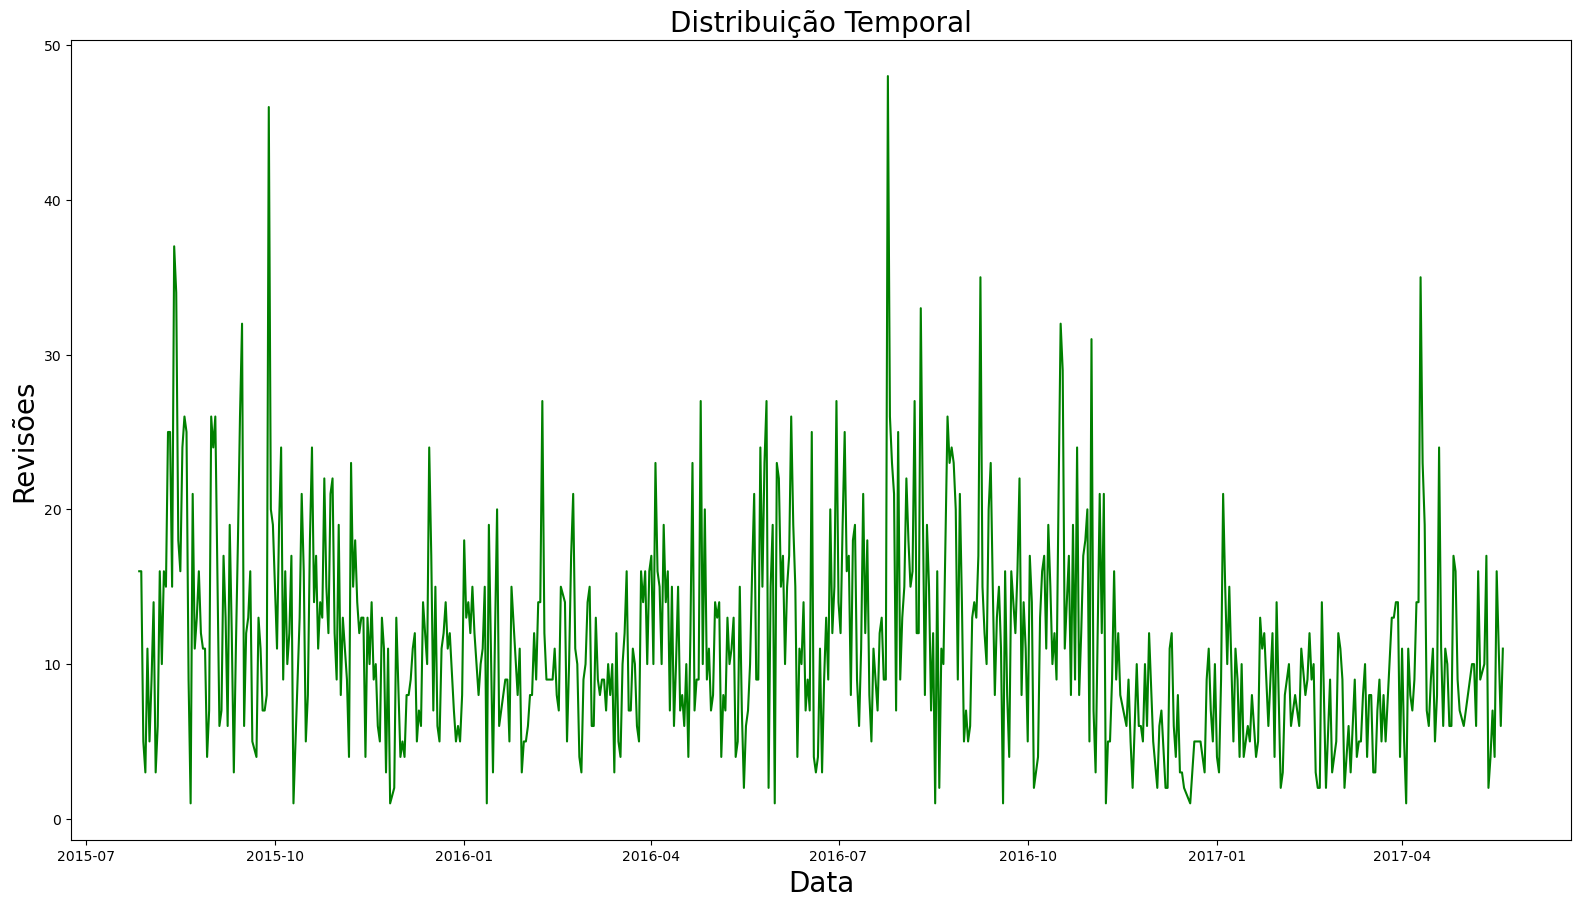

In [487]:
fig = plt.figure(figsize=(15,8))
plt.rcParams["figure.autolayout"] = True
eixo = fig.add_axes([0, 0, 1, 1])
dfEiffelDistr=dfEiffelDate.groupby("date").count().sort("date").toPandas()
eixo.plot(dfEiffelDistr["date"], dfEiffelDistr["count"], color= 'green')
plt.title('Temperatura no tempo')


eixo.set_title('Distribuição Temporal', fontsize=20)
eixo.set_ylabel('Revisões', fontsize=20)
eixo.set_xlabel('Data', fontsize=20)

In [ ]:
https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/spark_session.html